<a href="https://colab.research.google.com/github/arvshaphd7/BigCats-Classifier/blob/main/1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *

In [5]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [6]:
ims = search_images_ddg('leopard')
len(ims)
# this has downloaded urls of 200 images of leopard

200

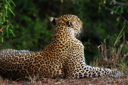

In [7]:
# code to look at one of the images
dest = 'images/leopard.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
# code to download all the url's of each of the search terms, and then put them in sepearate folders
bigCats_types = 'Panther','Tiger','Leopard','Snow leopard','Lion'
path = Path('bigCats')

if not path.exists():
    path.mkdir(exist_ok = True)
    ind = 0
    for o in bigCats_types:
      dest = (path/o)
      dest.mkdir(exist_ok=True)
      results = search_images_ddg(f'{o} bigCats', max_images=300)
      for i in results:
        ind +=1
        dest = f"bigCats/{o}/{o}{ind}.jpg"
        try:
          path1, dirs, files = next(os.walk(f"/content/bigCats/{o}"))
          if len(files) < 100:
            download_url(i, dest)
          else:
            break
        except:
          continue

In [ ]:
# image paths in the folder
fns = get_image_files(path)
fns

In [ ]:
# corrupt downloaded files
failed = verify_images(fns)
failed

In [ ]:
#code to unlink all the failed images
failed.map(Path.unlink);

In [ ]:
# stores the object and make them available as train and valid 
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i,self: self[i])

In [ ]:
bigCats = DataBlock(
  blocks=(ImageBlock, CategoryBlock), # independent variable = from which we make predictions (i.e. set of images), Dependent variable : differnet catagories (i.e. type of bigCat)
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=Resize(128))

In [ ]:
dls = bigCats.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bigCats = bigCats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bigCats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bigCats = bigCats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bigCats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bigCats =bigCats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls =bigCats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
bigCats = bigCats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bigCats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
bigCats = bigCats.new(
  item_tfms=RandomResizedCrop(224, min_scale=0.5),
  batch_tfms=aug_transforms())
dls = bigCats.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import *

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/leopard.jpg')

In [ ]:
dest = 'images/leopard.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
learn_inf.dls.vocab


In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your bear!'),
  btn_upload, btn_run, out_pl, lbl_pred])